# Importing Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import glob
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
import keras, keras_preprocessing
from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Flatten
from keras.layers import LSTM, Lambda
from keras.layers import TimeDistributed
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import Iterator
from keras.models import load_model
from keras.models import Model, model_from_json

import warnings
warnings.filterwarnings('ignore')

from viz_utils import plot_loss_curves, plot_errors, plot_changes_in_r, return_difference
from viz_utils import conditioned_ssim, sharpness_difference_grad, sharpness, sharpness_difference

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
plt.rcParams['figure.figsize'] = 30,15

Using TensorFlow backend.


In [3]:
from viz_utils import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initializing globals

In [4]:
# delete old models folder
suffix = "1ss" # set to "" for 4 numbers
out_folder = "moving_mnist_results"
seed = None
# np.random.seed(seed)
# tf.set_random_seed(seed)

data_dict = {
    "weight_dir" : os.path.join(os.getcwd(), out_folder),
    "result_dir" : os.path.join(os.getcwd(), out_folder, "results"),
    "json_file" : os.path.join(os.getcwd(), out_folder, "model.json"),
    "weights_file": os.path.join(os.path.join(os.getcwd(), out_folder), 'prednet_mnist_weights.hdf5'),
    "json_file": os.path.join(os.path.join(os.getcwd(), out_folder), 'prednet_mnist_model.json'),
    "nt": 18,
    "datafile" : "../data/data{}.npy".format(suffix),
    "datalabelsfile" : "../data/data{}_labels.npy".format(suffix),
    "nval" : 1000,
    "nb_epochs" : 150,
    "batch_size" : 32,
    "samples_per_epoch" : None,
    "N_seq_val" : None,
    "n_channels" : 1,
    "im_height" : 64,
    "im_width" : 64,
    "n_chan_layer" : [32, 64, 96, 128], #(1,32,64,128,256)
    "n_chan_R_layer" : [],
    "layer_loss" : [1., 0., 0., 0., 0.],
    "a_filt_sizes": (3, 3, 3, 3),
    "ahat_filt_sizes": (3, 3, 3, 3, 3),
    "r_filt_sizes": (3, 3, 3, 3, 3),
    "lr": 0.0003, # 0.001- 0.0008 - 0.0005 - 0.0001
    "lr_reduce_epoch": 10,
    "multitask": True,
    "std_param": 0.5,
    "strided_conv_pool": False,
    "nb_classes" : 8,
    "n_chan_lbl_layer" : [256],
    "second_loss_weight":0.0000
    }

# Loading Data

In [5]:
# Load moving numbers dataset
data = np.load(data_dict["datafile"]).astype(float) / 255
labels = np.load(data_dict["datalabelsfile"])
print("loaded dataset {} with shape={}".format(data_dict["datafile"], data.shape))
# move channel axis to the end and split into train and test
data = np.moveaxis(data, 2, -1)

_n = 0
train_data = data[_n:-data_dict["nval"],]
val_data = data[-data_dict["nval"]:,]
train_label = labels[_n:-data_dict["nval"]]
val_label = labels[-data_dict["nval"]:]
assert train_data.shape[0] == train_label.shape[0]
assert val_data.shape[0] == val_label.shape[0]

n, nt, im_height, im_width, n_channels =  train_data.shape
print("train split shape={}\t val split shape={}".format(train_data.shape, val_data.shape))

loaded dataset ../data/data1ss.npy with shape=(10000, 20, 1, 64, 64)
train split shape=(9000, 20, 64, 64, 1)	 val split shape=(1000, 20, 64, 64, 1)


In [6]:
# reformulate as a 8-class classification problem
directions = ["left","top-left","top","top-right",
              "right","bot-right","bot","bot-left"]

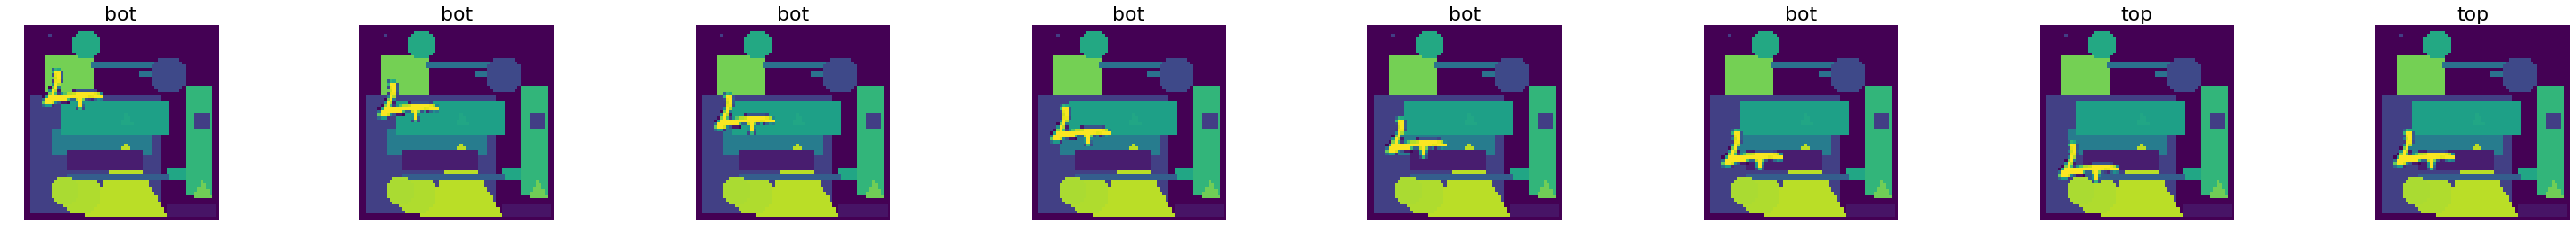

In [7]:
# plot 5 samples
rand_idxs = np.random.randint(0, len(train_data), 1)

n = data_dict["nt"] if data_dict["nt"]<=8 else 8 
for i in rand_idxs:
    x = train_data[i]
    label = labels[i]
        
    f,axs = plt.subplots(1,n,figsize=(3*data_dict["nt"],4))
    for j in range(n):
        axs[j].axis("off")
        axs[j].imshow(x[j].squeeze())
        axs[j].set_title(directions[int(label[j,0,-1])], fontdict = {'fontsize' : 400//data_dict["nt"]})
        
    plt.subplots_adjust(wspace=0.0001, hspace=0.0001)
    plt.show()

# Building and training model

In [8]:
from prednet import PredNet

In [9]:
# create weight directory if it does not exist
if not os.path.exists(data_dict["weight_dir"]):
    os.makedirs(data_dict["weight_dir"])
    os.chmod(data_dict['weight_dir'], mode=0o777)
    
if not os.path.exists(data_dict["result_dir"]):
    os.makedirs(data_dict["result_dir"])
    os.chmod(data_dict['result_dir'], mode=0o777)

In [10]:
n_channels, im_height, im_width = (data_dict['n_channels'], data_dict['im_height'], data_dict['im_width'])
input_shape = (n_channels, im_height, im_width) if K.image_data_format() == 'channels_first' else (
        im_height, im_width, n_channels)
stack_sizes = tuple([data_dict["n_channels"]] + data_dict["n_chan_layer"])
if(len(data_dict["n_chan_R_layer"]) != 0): 
    r_stack_sizes = tuple([data_dict["n_channels"]] + data_dict["n_chan_R_layer"])
else:
    r_stack_sizes = stack_sizes

In [11]:
# weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
# Checking if all the values in layer_loss are between 0.0 and 1.0
# Checking if the length of all layer loss list is equal to the number of prednet layers
assert all(1.0 >= i >= 0.0 for i in data_dict["layer_loss"]) and len(data_dict["layer_loss"]) == len(stack_sizes)
layer_loss_weights = np.array(data_dict["layer_loss"])
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)

# equally weight all timesteps except the first
time_steps = data_dict["nt"]
time_loss_weights = 1. / (time_steps - 1) * np.ones((time_steps, 1))
time_loss_weights[0] = 0

In [12]:
inputs = Input(shape=(time_steps,) + input_shape)
nb_layers = len(data_dict['n_chan_layer'])+1

In [13]:
# sparse_categorial_crossentropy_with_logits loss function for labels
def CEloss(y_true, y_pred, n=data_dict['nt']):
    loss = 0
    for i in range(n):
        loss += K.categorical_crossentropy(target=y_true[:,i], output=y_pred[:,i])
    loss = (loss/n)*data_dict["second_loss_weight"] # weighing the loss
    return loss

In [14]:
if(data_dict['multitask']):
        output_mode='error_and_label'
        # Configuring the model
        prednet = PredNet(stack_sizes, r_stack_sizes, data_dict["a_filt_sizes"], data_dict["ahat_filt_sizes"], 
                          data_dict["r_filt_sizes"], return_sequences=True, output_mode=output_mode, 
                          strided_conv_pool=data_dict["strided_conv_pool"], nb_classes=data_dict['nb_classes'],
                          lbl_stack_sizes=data_dict['n_chan_lbl_layer']) 
        # errors will be (batch_size, nt, nb_layers), labels will be (batch_size, nt, num_classes)
        errors_and_labels = prednet(inputs)
        errors = Lambda(lambda x: x[:,:,:nb_layers], output_shape=(time_steps,nb_layers,))(errors_and_labels)
        labels = Lambda(lambda x: x[:,:,nb_layers:], name='label', output_shape=(time_steps,data_dict['nb_classes']))(errors_and_labels)
        
        # calculate weighted error by layer
        errors_by_time = TimeDistributed(Dense(1, trainable=False), weights=[layer_loss_weights, np.zeros(1)],
                                         trainable=False)(errors)
        # will be (batch_size, nt)
        errors_by_time = Flatten()(errors_by_time)  
        # weight errors by time
        final_errors = Dense(1, weights=[time_loss_weights, np.zeros(1)], trainable=False, name='y')(
            errors_by_time) 

        # weighed sum of all label predictions over time
#         labels = Lambda(lambda x: K.permute_dimensions(x,(0,2,1)))(labels)
        # get_exp_t_weights() returns the weights that start at 0.0 and raise exponentially to 1.0 and plateau. 
        # Motivated by our prior belief that the model is allowed to slowly learn the right prediction class over time.
#         time_label_weights = get_exp_t_weights(time_steps)
        # weight labels by time      
#         final_labels = Dense(1, weights=[time_loss_weights, np.zeros(1)], trainable=False)(
#             labels)

#         final_labels = Flatten(name='label')(final_labels)
        # final_labels = labels
        model = Model(inputs=inputs, outputs=([final_errors, labels]))
        
        model.compile(
            loss={'y': 'mean_absolute_error', 'label':CEloss }
            , optimizer='adam'
            , metrics={'y': ['mse'], 'label': ['acc']}
            )
else:
    output_mode='error'
    prednet = PredNet(stack_sizes, r_stack_sizes,
                      data_dict["a_filt_sizes"], data_dict["ahat_filt_sizes"], data_dict["r_filt_sizes"],
                      output_mode=output_mode, return_sequences=True)
    errors = prednet(inputs)
    
    errors_by_time = TimeDistributed(Dense(1, trainable=False), weights=[layer_loss_weights, np.zeros(1)], trainable=False)(errors)  # calculate weighted error by layer
    errors_by_time = Flatten()(errors_by_time)  # will be (batch_size, nt)
    final_errors = Dense(1, weights=[time_loss_weights, np.zeros(1)], trainable=False)(errors_by_time)  # weight errors by time
    model = Model(inputs=inputs, outputs=final_errors)
    model.compile(loss=data_dict['loss'], optimizer='adam')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 18, 64, 64, 1) 0                                            
____________________________________________________________________________________________________
pred_net_1 (PredNet)             (None, 18, 13)        7416794     input_1[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 18, 5)         0           pred_net_1[0][0]                 
____________________________________________________________________________________________________
time_distributed_1 (TimeDistribu (None, 18, 1)         6           lambda_1[0][0]                   
___________________________________________________________________________________________

# Creating Sequence generator class

In [16]:
# Data generator that creates sequences for input into PredNet.
class SequenceGenerator(Iterator):
    def __init__(self, data, nt, labels, data_dict, batch_size=8, shuffle=True, seed=None,
                 output_mode='error', sequence_start_mode='all', N_seq=None, n_classes=10,
                 data_format=K.image_data_format()):
        self.X = data  # X will be like (n_images, nb_cols, nb_rows, nb_channels)
        # self.sources = hkl.load(source_file) # source for each image so when creating sequences can assure that consecutive frames are from same video
        self.nt = nt
        self.batch_size = batch_size
        self.labels = labels
        self.n_classes = n_classes
        self.data_format = data_format
        assert sequence_start_mode in {'all', 'unique'}, 'sequence_start_mode must be in {all, unique}'
        self.sequence_start_mode = sequence_start_mode
        assert output_mode in {'error', 'prediction', 'label', 'error_and_label', 'prediction_and_label'}, 'output_mode must be in {error, prediction, label, error_and_label, prediction_and_label}'
        self.output_mode = output_mode

        if self.data_format == 'channels_first':
            self.X = np.transpose(self.X, (0, 3, 1, 2))
        self.im_shape = self.X[0][0].shape

        if self.sequence_start_mode == 'all':  # allow for any possible sequence, starting from any frame
            self.possible_starts = np.array(range(0, self.X.shape[1]-self.nt))

        if shuffle:
            self.possible_starts = np.random.permutation(self.possible_starts)
        if N_seq is not None and len(self.possible_starts) > N_seq:  # select a subset of sequences if want to
            self.possible_starts = self.possible_starts[:N_seq]
        self.N_sequences = len(self.possible_starts)
        super(SequenceGenerator, self).__init__(self.X.shape[0], batch_size, shuffle, seed)
    
    def next(self):
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        batch_x = np.zeros((current_batch_size, self.nt) + self.im_shape, np.float32)
        batch_label = np.zeros((current_batch_size, self.nt, self.n_classes), np.int32)
        for i, idx in enumerate(index_array):
            vid_idx = np.random.choice(self.possible_starts)
            batch_x[i] = self.preprocess(self.X[idx, vid_idx:vid_idx+self.nt])
            batch_label[i] = to_categorical(
                self.labels[idx, vid_idx:vid_idx+self.nt, 0, -1].astype(int), self.n_classes)
        if self.output_mode == 'error':  # model outputs errors, so y should be zeros
            batch_y = np.zeros(current_batch_size, np.float32)
        elif self.output_mode == 'prediction':  # output actual pixels
            batch_y = batch_x
        elif 'label' in self.output_mode:
            # one_hot_encode the label
            labels = batch_label
            if self.output_mode == 'label':
                batch_y = labels
            elif self.output_mode == 'error_and_label':         
                batch_y = {'y': np.zeros(current_batch_size, np.float32), 'label': labels}
            elif self.output_mode == 'prediction_and_label':            
                batch_y = {'y': batch_x, 'label': labels}
            else:
                raise NotImplementedError
        else:
            raise NotImplementedError
        
        return batch_x, batch_y

    def preprocess(self, X):
        return X.astype(np.float32) / 255

    def create_all(self):
        X_all = np.zeros((self.N_sequences, self.nt) + self.im_shape, np.float32)
        for i, idx in enumerate(self.possible_starts):
            vid_idx = np.random.choice(self.possible_starts)
            X_all[i] = self.preprocess(self.X[idx, vid_idx:vid_idx+self.nt])
        return X_all

In [17]:
if data_dict['multitask'] == True:
    train_generator = SequenceGenerator(train_data, data_dict['nt'] , train_label, data_dict, batch_size=data_dict['batch_size'], output_mode='error_and_label', n_classes=data_dict["nb_classes"], shuffle=True, seed=seed)
    val_generator = SequenceGenerator(val_data, data_dict['nt'] , val_label, data_dict, batch_size=data_dict['batch_size'], output_mode='error_and_label', n_classes=data_dict["nb_classes"], shuffle=False, seed=seed)
else:
    train_generator = SequenceGenerator(train_data, data_dict['nt'] ,None, data_dict, batch_size=data_dict['batch_size'], n_classes=data_dict["nb_classes"], shuffle=True, seed=seed)
    val_generator = SequenceGenerator(val_data, data_dict['nt'] ,None, data_dict, batch_size=data_dict['batch_size'], n_classes=data_dict["nb_classes"], shuffle=False, seed=seed)

shapes X=(32, 18, 64, 64, 1) 	 Y=(32, 18, 8)
Label [[0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1]]


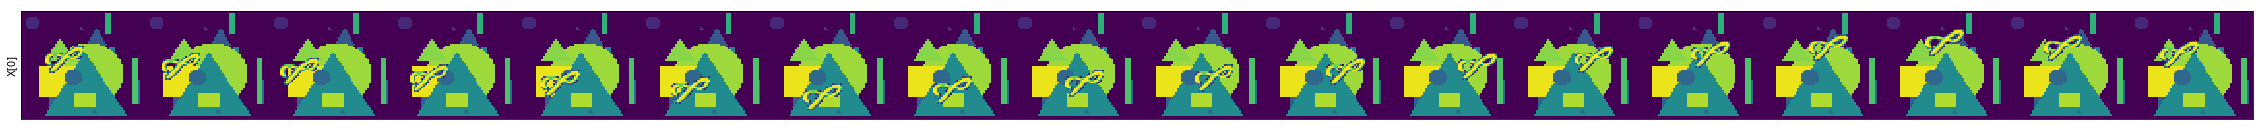

In [18]:
# visualize the generator output
X, Y = next(val_generator)
print("shapes X={} \t Y={}".format(X.shape, Y['label'].shape))
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(nt*2,2))
# plot X[0]
X = X[0,:,:,:,0]
ax.imshow(np.concatenate([t for t in X[:,:,:]], axis=1), interpolation='none', aspect="auto")
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax.set_ylabel(r'X[0]', fontsize=10)
ax.set_xlim(0,time_steps*im_width)

print("Label",Y['label'][0])

In [ ]:
lr_schedule = lambda e : data_dict['lr']*(1 - 0.1*(e//data_dict['lr_reduce_epoch'])) if e//data_dict['lr_reduce_epoch']<10 else 0.1*data_dict['lr']
callbacks = [LearningRateScheduler(lr_schedule)]

In [ ]:
if not os.path.exists(data_dict['weight_dir']): 
    os.mkdir(data_dict['weight_dir'])
    os.chmod(data_dict['weight_dir'], mode=0o777)
callbacks.append(ModelCheckpoint(filepath=data_dict['weights_file'], monitor='val_loss', save_best_only=True))
callbacks.append(EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=25, verbose=1,
                      mode='auto'))

In [ ]:
with open(data_dict['json_file'], "w") as f:
    f.write(model.to_json())

In [ ]:
steps_per_epoch = data_dict['samples_per_epoch']//data_dict['batch_size'] if data_dict['samples_per_epoch'] is not None else train_generator.n//data_dict['batch_size']
validation_steps = int(data_dict['N_seq_val']/data_dict['batch_size']) if  data_dict['N_seq_val'] is not None else val_generator.n//data_dict['batch_size']

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=data_dict['nb_epochs'],
                              callbacks=callbacks, 
                              validation_data=val_generator, 
                              validation_steps=validation_steps)

Epoch 1/150
281/281 [==============================] - 430s - loss: 1.8717e-04 - y_loss: 1.8717e-04 - label_loss: 0.0000e+00 - y_mean_squared_error: 4.3768e-08 - label_acc: 0.1264 - val_loss: 1.2815e-04 - val_y_loss: 1.2815e-04 - val_label_loss: 0.0000e+00 - val_y_mean_squared_error: 1.6862e-08 - val_label_acc: 0.1194
Epoch 2/150
281/281 [==============================] - 437s - loss: 1.1039e-04 - y_loss: 1.1039e-04 - label_loss: 0.0000e+00 - y_mean_squared_error: 1.2570e-08 - label_acc: 0.1291 - val_loss: 1.0249e-04 - val_y_loss: 1.0249e-04 - val_label_loss: 0.0000e+00 - val_y_mean_squared_error: 1.0825e-08 - val_label_acc: 0.1284
Epoch 3/150
281/281 [==============================] - 434s - loss: 9.6333e-05 - y_loss: 9.6333e-05 - label_loss: 0.0000e+00 - y_mean_squared_error: 9.5927e-09 - label_acc: 0.1266 - val_loss: 9.0316e-05 - val_y_loss: 9.0316e-05 - val_label_loss: 0.0000e+00 - val_y_mean_squared_error: 8.4354e-09 - val_label_acc: 0.1197
Epoch 4/150
281/281 [===================

In [ ]:
# save training history to a file
with open(os.path.join(data_dict['result_dir'], 'training_history.json'), 'w') as f:
    json.dump(history.history, f, sort_keys=True, indent=4)

# Checking Predictions

In [ ]:
# Loading best model
# data_dict['json_file'] = os.path.join(os.path.join(os.getcwd(), "mnist_best_prednet"), 'prednet_mnist_model.json')
# data_dict['weights_file'] = os.path.join(os.path.join(os.getcwd(), "mnist_best_prednet"), 'prednet_mnist_weights.hdf5')

# Loading trained model
with open(data_dict['json_file'], 'r') as f:
    json_string = f.read()

model = model_from_json(json_string, custom_objects={'PredNet': PredNet, 'nb_layers':nb_layers})
model.load_weights(data_dict['weights_file'])

In [ ]:
# Create testing model (to output predictions)
layer_config = model.layers[1].get_config()
if(data_dict["multitask"]):
    output_mode = 'prediction_and_label' 
else:
    output_mode = 'prediction'
layer_config['output_mode'] = output_mode
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
test_prednet = PredNet(weights=model.layers[1].get_weights(), **layer_config)
input_shape = list(model.layers[0].batch_input_shape[1:])
input_shape[0] = time_steps
inputs = Input(shape=tuple(input_shape))
predictions = test_prednet(inputs)
test_model = Model(inputs=inputs, outputs=predictions)

In [ ]:
 #initialize lists for evaluation        
mse_model_list, mse_prev_list, mae_model_list, mae_prev_list = ([] for i in range(4))
psnr_list, ssim_list, sharpness_grad_list, psnr_prev_list, ssim_prev_list, sharpness_grad_prev_list = ([] for i in range(6))
psnr_movement_list, psnr_movement_prev_list, ssim_movement_list, ssim_movement_prev_list =  ([] for i in range(4))
conditioned_ssim_list, sharpness_list, sharpness_prev_list = ([] for i in range(3))
accuracy_list = []

In [ ]:
# TODO:  adhoc to speed things up 
data_dict['batch_size'] = 128
max_test_batches = val_generator.n // 128 # adhoc, only run on few batches (/8)

for index, data in enumerate(val_generator):
    # Only consider steps_test number of steps
    if index > max_test_batches:
        break
    # X_test = test_generator.next()[0]
    X_test = data[0]        

    if(data_dict['multitask']==True):
        lbl = data[1]['label']
        lbl_final = lbl.argmax(axis=-1)
        X_hat_with_lbl = test_model.predict(X_test, data_dict['batch_size'])
        X_hat, lbl_hat = X_hat_with_lbl[:,:,:-data_dict["nb_classes"]], X_hat_with_lbl[:,:,-data_dict["nb_classes"]:]
        # print("<d>", lbl_hat.shape, lbl_hat.max(), lbl_hat.min(), lbl_hat.mean())
        X_hat  = np.reshape(X_hat, X_test.shape) 
#         lbl_pred_final_logits = np.moveaxis(lbl_hat,1,2).dot(get_exp_t_weights(time_steps)).squeeze()
        lbl_pred_final = lbl_hat.argmax(axis=-1)
        if index==0: 
            # visualize the predicted labels for the first round
            for i in range(-data_dict['nt']-3,-data_dict['nt']):
                print("\nExpected labels  = \n", [directions[l] for l in lbl_final[i]]) 
                print("Predicted labels = \n", [directions[l] for l in lbl_pred_final[i]])
        acc = (lbl_pred_final == lbl_final).mean()
        print("{}, accuracy= {:.2f}%".format(index, acc*100))
        accuracy_list.append(acc)
    else:
        X_hat = test_model.predict(X_test, data_dict['batch_size'])
    if data_format == 'channels_first':
        X_test = np.transpose(X_test, (0, 1, 3, 4, 2))
        X_hat = np.transpose(X_hat, (0, 1, 3, 4, 2))

    # Compare the scores of PredNet predictions vs. using last frame.  Write results to prediction_scores.txt
    # mean square error
    mse_model_list.append(
        np.mean((X_test[:, 1:] - X_hat[:, 1:]) ** 2))  # look at all timesteps except the first
    mse_prev_list.append(np.mean((X_test[:, :-1] - X_test[:, 1:]) ** 2))
    # mean absolute error
    mae_model_list.append(
        np.mean(np.abs(X_test[:, 1:] - X_hat[:, 1:])))
    mae_prev_list.append(np.mean(np.abs(X_test[:, :-1] - X_test[:, 1:])))
    # ssim
    ssim_list.append(np.mean([return_difference(X_test[ind][1:], X_hat[ind][1:])[0] for ind in range(X_test.shape[0])]))
    ssim_prev_list.append(np.mean([return_difference(X_test[ind][:-1], X_test[ind][1:])[0] 
                                   for ind in range(X_test.shape[0]-1)]))
    ssim_movement_list.append(np.mean([return_difference(X_test[ind], X_hat[ind])[2] 
                                       for ind in range(X_test.shape[0])]))
    ssim_movement_prev_list.append(np.mean([return_difference(X_test[ind][:-1], X_test[ind][1:])[2] 
                                   for ind in range(X_test.shape[0]-1)])) 
    conditioned_ssim_list.append(np.mean([conditioned_ssim(X_test[ind], X_hat[ind]) 
                                   for ind in range(X_test.shape[0])])) 

    # psnr
    psnr_list.append(np.mean([return_difference(X_test[ind][1:], X_hat[ind][1:])[1] for ind in range(X_test.shape[0])]))            
    psnr_prev_list.append(np.mean([return_difference(X_test[ind][:-1], X_test[ind][1:])[1] 
                                   for ind in range(X_test.shape[0]-1)]))
    psnr_movement_list.append(np.mean([return_difference(X_test[ind], X_hat[ind])[3] 
                                       for ind in range(X_test.shape[0])]))
    psnr_movement_prev_list.append(np.mean([return_difference(X_test[ind][:-1], X_test[ind][1:])[3] 
                                   for ind in range(X_test.shape[0]-1)]))

    # sharpness
#     sharpness_grad_list.append(np.mean([sharpness_difference_grad(X_test[ind][1:], X_hat[ind][1:])
#                                    for ind in range(X_test.shape[0])]))
    #sharpness_grad_prev_list.append(np.mean([sharpness_difference_grad(X_test[ind][:-1], X_test[ind][1:])
    #                                    for ind in range(X_test.shape[0]-1)]))

#     sharpness_list.append(np.mean([sharpness_difference(X_test[ind][1:], X_hat[ind][1:])
#                                   for ind in range(X_test.shape[0])]))
    #sharpness_prev_list.append(np.mean([sharpness_difference(X_test[ind][:-1], X_test[ind][1:])
    #                               for ind in range(X_test.shape[0])]))

    
# save in a dict and limit the size of float decimals to max 6
results_dict = {                    
"MSE_mean": float("{:.10f}".format(np.mean(mse_model_list))), 
"MSE_std":float(("{:.10f}".format(np.std(mse_model_list)))), 
"MSE_mean_prev_frame_copy":float("{:.10f}".format(np.mean(mse_prev_list))), 
"MSE_std_prev_frame_copy":float("{:.10f}".format(np.std(mse_prev_list))),
"MAE_mean": float("{:.6f}".format(np.mean(mae_model_list))), 
"MAE_std":float(("{:.6f}".format(np.std(mae_model_list)))), 
"MAE_mean_prev_frame_copy":float("{:.6f}".format(np.mean(mae_prev_list))), 
"MAE_std_prev_frame_copy":float("{:.6f}".format(np.std(mae_prev_list))),
"SSIM_mean": float("{:.6f}".format(np.mean(ssim_list))), 
"SSIM_mean_prev_frame_copy": float("{:.6f}".format(np.mean(ssim_prev_list))), 
"SSIM_movement_mean": float("{:.6f}".format(np.mean(ssim_movement_list))), 
"SSIM_movement_mean_prev_frame_copy": float("{:.6f}".format(np.mean(ssim_movement_prev_list))), 
"Conditioned_SSIM_mean": float("{:.6f}".format(np.mean(conditioned_ssim_list))),
"PSNR_mean": float("{:.6f}".format(np.mean(psnr_list))),
"PSNR_mean_prev_frame_copy": float("{:.6f}".format(np.mean(psnr_prev_list))), 
"PSNR_movement_mean": float("{:.6f}".format(np.mean(psnr_movement_list))), 
"PSNR_movement_mean_prev_frame_copy": float("{:.6f}".format(np.mean(psnr_movement_prev_list))), 
"Sharpness_grad_mean": float("{:.6f}".format(np.mean(sharpness_grad_list))),
#"Sharpness_grad_mean_prev_frame_copy": float("{:.6f}".format(np.mean(sharpness_grad_prev_list))),
"Sharpness_difference_mean": float("{:.6f}".format(np.mean(sharpness_list)))
#"Sharpness_difference_mean_prev_frame_copy" : float("{:.6f}".format(np.mean(sharpness_prev_list)))
}

In [ ]:
print("model results for training dataset:")
results_dict

In [ ]:
results_dict['MSE_mean']

In [ ]:
with open(os.path.join(data_dict['result_dir'], 'mnist_scores.json'), 'w') as f:
    json.dump(results_dict, f, sort_keys=True,  indent=4)

# Creating extra plots

In [ ]:
extra_plot_flag = False

plot_save_dir = os.path.join(data_dict['result_dir'], 'predictions')
if not os.path.exists(plot_save_dir):
    os.makedirs(plot_save_dir)

assert X_test.shape==X_hat.shape

In [ ]:
if extra_plot_flag:
    #Create models for error and R plots
    extra_test_models = []
    no_layers = len(test_prednet.stack_sizes)
    extra_output_modes = (['E'+str(no) for no in range(no_layers)] + ['A'+str(no) for no in range(no_layers)] 
                        + ['Ahat'+str(no) for no in range(no_layers)] + ['R'+str(no) for no in range(no_layers)])

    for output_mode in extra_output_modes:
        if(data_dict['multitask'] == True):
            output_mode += "_and_label"
        layer_config['output_mode'] = output_mode    
        data_format = (layer_config['data_format'] if 'data_format' in layer_config 
                        else layer_config['dim_ordering'])
        extra_test_prednet = PredNet(weights=model.layers[1].get_weights(), **layer_config)
        input_shape = list(model.layers[0].batch_input_shape[1:])
        input_shape[0] = data_dict['nt']
        inputs = Input(shape=tuple(input_shape))
        extra_predictions = extra_test_prednet(inputs)
        extra_test_model = Model(inputs=inputs, outputs=extra_predictions)
        extra_test_models.append((extra_test_model, output_mode))
    
    #Create outputs for extra plots
    error_X_hats = []
    R_X_hats = []
    A_X_hats = []
    Ahat_X_hats = []
    for test_model, output_mode in extra_test_models:
        if output_mode[0]=='R':
            R_X_hat = test_model.predict(X_test) 
            R_X_hats.append((R_X_hat, output_mode))
        elif output_mode[0]=='E':
            error_X_hat = test_model.predict(X_test) 
            error_X_hats.append((error_X_hat, output_mode))
        elif 'Ahat' in output_mode: 
            Ahat_X_hat = test_model.predict(X_test) 
            Ahat_X_hats.append((Ahat_X_hat, output_mode))
        else: # output_mode[0]=='A':
            A_X_hat = test_model.predict(X_test) 
            A_X_hats.append((A_X_hat, output_mode))

In [ ]:
# sample 'plots_per_grp' videos from each sub-group
aspect_ratio = float(X_hat.shape[2]) / X_hat.shape[3]
for i in range(3):      #len(X_test)    
    if extra_plot_flag:
        fig, ax = plt.subplots(ncols=1, nrows=20, sharex=True, figsize=(time_steps, 25 * aspect_ratio),
                              gridspec_kw={'height_ratios':[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3]})
    else:
        fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(time_steps, 2 * aspect_ratio))

    # set the title of the plot as the label and the video ID for reference
    if(data_dict['multitask']):
        title = "{}) TRUE {}\n PRED: {}".format(
        i, 
        [directions[lbl] for lbl in lbl_final[i]],
        [directions[lbl] for lbl in lbl_pred_final[i]])
    else:
        title = "{}) Digit {}".format( # Pos {}
        i, 
        np.unique(val_label[i,0,:,0].astype(int))
#         ,val_label[i,:,0,1:]
)

    fig.suptitle(title, fontsize=10)

    #Plot video
    ax = plt.subplot()
    ax.imshow(np.concatenate([t for t in X_test[i,:,:,:,0]], axis=1), interpolation='none', aspect="auto")
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                                    labelbottom=False, labelleft=False)
    ax.set_ylabel(r'Actual', fontsize=10)
    ax.set_xlim(0,time_steps*im_width)

    #Plot predictions
    divider = make_axes_locatable(ax)
    ax = divider.append_axes("bottom", size="100%", pad=0.0)                                             
    ax.imshow(np.concatenate([t for t in X_hat[i,:,:,:,0]], axis=1), interpolation='none', aspect="auto")
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                                    labelbottom=False, labelleft=False)
    ax.set_ylabel(r'Prediction', fontsize=10)
    ax.set_xlim(0,time_steps*im_width)
    
    if extra_plot_flag:
        #Create values for R plots      
        results = plot_changes_in_r(R_X_hats, i, std_param=data_dict['std_param'])
        ax = divider.append_axes("bottom", size="300%", pad=0.2)                                                                
        #Plot R plots
        for layer in results:
            (y,x,std) = layer[0]
            x = [im_width/2+item*im_width for item in x]
            ax.fill_between(x, [(val-data_dict['std_param']*dev) for val,dev in zip(y,std)], 
                             [(val+data_dict['std_param']*dev) for val,dev in zip(y,std)], alpha=0.1)
            ax.plot(x, y)

        ax.set_xlim(0,time_steps*im_width)
        ax.set_xticks(np.arange(im_width/2, time_steps*im_width, step=im_width))                
        ax.set_xticklabels(np.arange(1,time_steps+1))
        ax.grid(True)                  
        ax.set_ylabel(r"Mean R activations", fontsize=10)
        ax.xaxis.set_label_position('top') 
        ax.legend(['R'+str(no) for no in range(no_layers)], loc='center left')

        #Create values for E plots      
        results = plot_changes_in_r(error_X_hats, i, std_param=data_dict['std_param'])
        ax = divider.append_axes("bottom", size="300%", pad=0.2)                                                                
        #Plot E plots
        for layer in results:
            (y,x,std) = layer[0]
            x = [im_width/2+item*im_width for item in x]
            ax.fill_between(x, [(val-data_dict['std_param']*dev) for val,dev in zip(y,std)], 
                            [(val+data_dict['std_param']*dev) for val,dev in zip(y,std)], alpha=0.1)
            ax.plot(x, y)

        ax.set_xlim(0,time_steps*im_width)
        ax.set_xticks(np.arange(im_width/2, time_steps*im_width, step=im_width))                
        ax.set_xticklabels(np.arange(1,time_steps+1))
        ax.grid(True)                  
        ax.set_ylabel(r"Mean E activations", fontsize=10)
        ax.xaxis.set_label_position('top') 
        ax.legend(['E'+str(no) for no in range(no_layers)], loc='center left')

        #Create error output matrices to plot inside the next loop
        R_matrices = plot_errors(R_X_hats, X_test, ind=i)
        A_matrices =  plot_errors(A_X_hats, X_test, ind=i) 
        Ahat_matrices = plot_errors(Ahat_X_hats, X_test, ind=i)
        error_matrices = plot_errors(error_X_hats, X_test, ind=i)
        #Plot R, A, Ahat and errors for each layer
        for layer in range(len(error_matrices)):   
                ##R
                ax = divider.append_axes("bottom", size="100%", pad=0.2)                                             
                ax.imshow(np.concatenate([t for t in R_matrices[layer]], axis=1), 
                                   interpolation='nearest', cmap='gray', aspect="auto")
                ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, 
                                        right=False, labelbottom=False, labelleft=False)
                ax.set_ylabel(r"R" + str(layer), fontsize=10)
                ax.set_xlabel(r"Layer " + str(layer), fontsize=10)
                ax.xaxis.set_label_position('top') 
                ax.set_xlim(0,time_steps*im_width)
                ##A
                ax = divider.append_axes("bottom", size="100%", pad=0.0)                                             
                ax.imshow(np.concatenate([t for t in Ahat_matrices[layer]], axis=1), 
                                   interpolation='nearest', cmap='gray', aspect="auto")
                ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, 
                                        right=False, labelbottom=False, labelleft=False)
                ax.set_ylabel(r"Ahat" + str(layer), fontsize=10)
                ax.set_xlim(0,time_steps*im_width)
                ##Ahat
                ax = divider.append_axes("bottom", size="100%", pad=0.0)                                     
                ax.imshow(np.concatenate([t for t in A_matrices[layer]], axis=1), 
                                   interpolation='nearest', cmap='gray', aspect="auto")
                ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, 
                                        right=False, labelbottom=False, labelleft=False)
                ax.set_ylabel(r"A" + str(layer), fontsize=10)
                ax.set_xlim(0,time_steps*im_width)
                ##E
                ax = divider.append_axes("bottom", size="100%", pad=0.0)                                             
                ax.imshow(np.concatenate([t for t in error_matrices[layer]], axis=1), 
                                   interpolation='nearest', cmap='gray', aspect="auto")
                ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, 
                                        right=False, labelbottom=False, labelleft=False)
                ax.set_ylabel(r"E" + str(layer), fontsize=10)
                ax.set_xlim(0,time_steps*im_width)
    plt.tight_layout()
    fig.savefig(plot_save_dir+"/"+"prediction"+str(i))
    plt.show()